In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 64)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 11.1015 - acc: 0.0989
Epoch 00001: val_loss improved from inf to 11.40214, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_1_conv_checkpoint/001-11.4021.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 11.1018 - acc: 0.0989 - val_loss: 11.4021 - val_acc: 0.0974
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 8.5655 - acc: 0.2978
Epoch 00002: val_loss did not improve from 11.40214
36805/36805 [==============================] - 84s 2ms/sample - loss: 8.5653 - acc: 0.2978 - val_loss: 12.4168 - val_acc: 0.1069
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 7.0220 - acc: 0.4354
Epoch 00003: val_loss did not improve from 11.40214
36805/36805 [==============================] - 84s 2ms/sample - loss: 7.0222 - acc: 0.4354 - val_

36800/36805 [============================>.] - ETA: 0s - loss: 3.3557 - acc: 0.7798
Epoch 00029: val_loss did not improve from 11.40214
36805/36805 [==============================] - 84s 2ms/sample - loss: 3.3562 - acc: 0.7797 - val_loss: 13.2965 - val_acc: 0.1512
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3469 - acc: 0.7809
Epoch 00030: val_loss did not improve from 11.40214
36805/36805 [==============================] - 84s 2ms/sample - loss: 3.3477 - acc: 0.7809 - val_loss: 12.2936 - val_acc: 0.2092
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3207 - acc: 0.7829
Epoch 00031: val_loss did not improve from 11.40214
36805/36805 [==============================] - 84s 2ms/sample - loss: 3.3206 - acc: 0.7829 - val_loss: 12.2062 - val_acc: 0.2148
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2866 - acc: 0.7859
Epoch 00032: val_loss did not improve from 11.40214
36805/36805 [=================

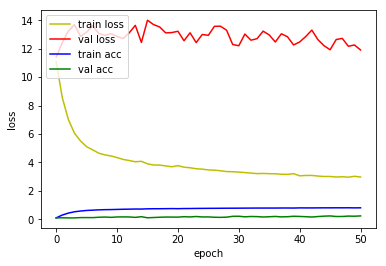

4815/4815 [==============================] - 4s 858us/sample - loss: 11.2598 - acc: 0.1047
Loss: 11.25984339788324 Accuracy: 0.104672894

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 4.8382 - acc: 0.2294
Epoch 00001: val_loss improved from inf to 10.68608, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_2_conv_checkpoint/001-10.6861.hdf5
36805/36805 [==============================] - 140s 4ms/sample - loss: 4.8382 - acc: 0.2293 - val_loss: 10.6861 - val_acc: 0.0955
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.1414 - acc: 0.4618
Epoch 00002: val_loss improved from 10.68608 to 9.67387, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_2_conv_checkpoint/002-9.6739.hdf5
36805/36805 [==============================] - 135s 4ms/sample - loss: 3.1417 - acc: 0.4618 - val_loss: 9.6739 - val_acc: 0.1826
Epoch 3/500
36800/36805 [==========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2764 - acc: 0.9704
Epoch 00029: val_loss did not improve from 7.81844
36805/36805 [==============================] - 135s 4ms/sample - loss: 0.2768 - acc: 0.9703 - val_loss: 9.7426 - val_acc: 0.3119
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2646 - acc: 0.9717
Epoch 00030: val_loss did not improve from 7.81844
36805/36805 [==============================] - 135s 4ms/sample - loss: 0.2645 - acc: 0.9717 - val_loss: 10.0306 - val_acc: 0.2900
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2693 - acc: 0.9713
Epoch 00031: val_loss did not improve from 7.81844
36805/36805 [==============================] - 135s 4ms/sample - loss: 0.2697 - acc: 0.9713 - val_loss: 10.5573 - val_acc: 0.2690
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2345 - acc: 0.9765
Epoch 00032: val_loss did not improve from 7.81844
36805/36805 [======

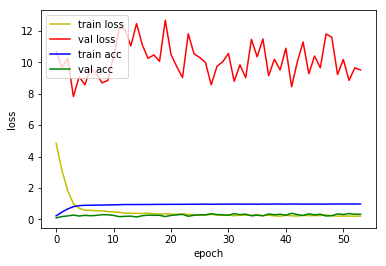

4815/4815 [==============================] - 6s 1ms/sample - loss: 8.1143 - acc: 0.2692
Loss: 8.11433346610698 Accuracy: 0.26915887

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5398 - acc: 0.3605
Epoch 00001: val_loss improved from inf to 5.41025, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_3_conv_checkpoint/001-5.4102.hdf5
36805/36805 [==============================] - 160s 4ms/sample - loss: 2.5401 - acc: 0.3605 - val_loss: 5.4102 - val_acc: 0.2313
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0479 - acc: 0.7041
Epoch 00002: val_loss did not improve from 5.41025
36805/36805 [==============================] - 152s 4ms/sample - loss: 1.0481 - acc: 0.7041 - val_loss: 7.5936 - val_acc: 0.2229
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3806 - acc: 0.8995
Epoch 00003: val_loss did not improve from 5.41025
36805/36805 [=====

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9898
Epoch 00029: val_loss did not improve from 4.05167
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0472 - acc: 0.9898 - val_loss: 6.8349 - val_acc: 0.3447
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9911
Epoch 00030: val_loss did not improve from 4.05167
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0439 - acc: 0.9911 - val_loss: 5.6858 - val_acc: 0.4104
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9939
Epoch 00031: val_loss did not improve from 4.05167
36805/36805 [==============================] - 152s 4ms/sample - loss: 0.0353 - acc: 0.9939 - val_loss: 6.4654 - val_acc: 0.3965
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0619 - acc: 0.9872
Epoch 00032: val_loss did not improve from 4.05167
36805/36805 [========

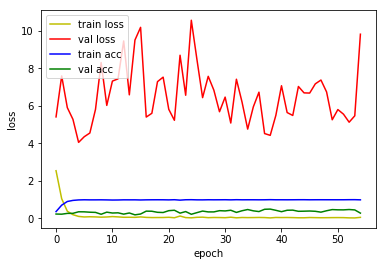

4815/4815 [==============================] - 7s 1ms/sample - loss: 4.3486 - acc: 0.3192
Loss: 4.348554058114564 Accuracy: 0.3192108

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0537 - acc: 0.4039
Epoch 00001: val_loss improved from inf to 2.55899, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_4_conv_checkpoint/001-2.5590.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 2.0536 - acc: 0.4039 - val_loss: 2.5590 - val_acc: 0.3410
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2404 - acc: 0.6282
Epoch 00002: val_loss did not improve from 2.55899
36805/36805 [==============================] - 158s 4ms/sample - loss: 1.2405 - acc: 0.6281 - val_loss: 4.3767 - val_acc: 0.2830
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8394 - acc: 0.7475
Epoch 00003: val_loss did not improve from 2.55899
36805/36805 [=====

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9925
Epoch 00029: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0344 - acc: 0.9925 - val_loss: 3.2303 - val_acc: 0.5052
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9920
Epoch 00030: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0349 - acc: 0.9920 - val_loss: 2.2645 - val_acc: 0.5905
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9957
Epoch 00031: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0244 - acc: 0.9956 - val_loss: 2.7049 - val_acc: 0.5514
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9970
Epoch 00032: val_loss did not improve from 2.19420
36805/36805 [========

Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0193 - acc: 0.9955
Epoch 00059: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0193 - acc: 0.9955 - val_loss: 2.5573 - val_acc: 0.6031
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9995
Epoch 00060: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0060 - acc: 0.9995 - val_loss: 2.5460 - val_acc: 0.6115
Epoch 61/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9988
Epoch 00061: val_loss did not improve from 2.19420
36805/36805 [==============================] - 158s 4ms/sample - loss: 0.0077 - acc: 0.9988 - val_loss: 2.9768 - val_acc: 0.5728
Epoch 62/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0100 - acc: 0.9983
Epoch 00062: val_loss did not improve from 2.19420
36805/36805 [========

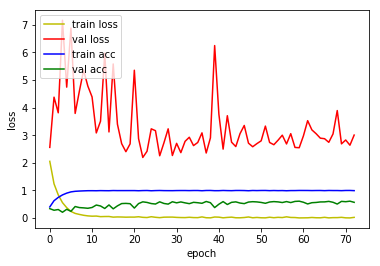

4815/4815 [==============================] - 7s 2ms/sample - loss: 2.4855 - acc: 0.5333
Loss: 2.4855427053734767 Accuracy: 0.53333336

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9385 - acc: 0.4226
Epoch 00001: val_loss improved from inf to 2.16017, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_5_conv_checkpoint/001-2.1602.hdf5
36805/36805 [==============================] - 181s 5ms/sample - loss: 1.9386 - acc: 0.4226 - val_loss: 2.1602 - val_acc: 0.3757
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2819 - acc: 0.6118
Epoch 00002: val_loss did not improve from 2.16017
36805/36805 [==============================] - 164s 4ms/sample - loss: 1.2818 - acc: 0.6118 - val_loss: 4.2740 - val_acc: 0.2749
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0080 - acc: 0.6936
Epoch 00003: val_loss improved from 2.16017 to 1.71760, saving mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9904
Epoch 00029: val_loss did not improve from 1.71760
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0460 - acc: 0.9903 - val_loss: 4.2271 - val_acc: 0.4684
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0429 - acc: 0.9916
Epoch 00030: val_loss did not improve from 1.71760
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0430 - acc: 0.9916 - val_loss: 2.5349 - val_acc: 0.5733
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9924
Epoch 00031: val_loss did not improve from 1.71760
36805/36805 [==============================] - 164s 4ms/sample - loss: 0.0379 - acc: 0.9924 - val_loss: 2.2198 - val_acc: 0.6201
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9877
Epoch 00032: val_loss did not improve from 1.71760
36805/36805 [=====================

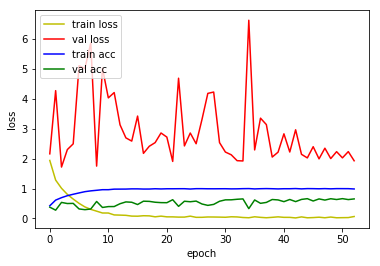

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.8931 - acc: 0.5034
Loss: 1.893113769474802 Accuracy: 0.5034268

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9341 - acc: 0.4071
Epoch 00001: val_loss improved from inf to 3.86839, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_6_conv_checkpoint/001-3.8684.hdf5
36805/36805 [==============================] - 192s 5ms/sample - loss: 1.9342 - acc: 0.4071 - val_loss: 3.8684 - val_acc: 0.2360
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2978 - acc: 0.6021
Epoch 00002: val_loss improved from 3.86839 to 1.46814, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_6_conv_checkpoint/002-1.4681.hdf5
36805/36805 [==============================] - 167s 5ms/sample - loss: 1.2979 - acc: 0.6021 - val_loss: 1.4681 - val_acc: 0.5570
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.1065 - acc: 0.9748
Epoch 00028: val_loss did not improve from 1.17844
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.1066 - acc: 0.9748 - val_loss: 1.6367 - val_acc: 0.6417
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0859 - acc: 0.9817
Epoch 00029: val_loss did not improve from 1.17844
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0860 - acc: 0.9817 - val_loss: 2.5498 - val_acc: 0.5537
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0892 - acc: 0.9795
Epoch 00030: val_loss did not improve from 1.17844
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0893 - acc: 0.9795 - val_loss: 1.3726 - val_acc: 0.7002
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9808
Epoch 00031: val_loss did not improve from 1.17844
36805/36805 [=====================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9938
Epoch 00057: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0339 - acc: 0.9938 - val_loss: 1.6500 - val_acc: 0.6813
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9918
Epoch 00058: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0394 - acc: 0.9918 - val_loss: 1.2836 - val_acc: 0.7417
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9921
Epoch 00059: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0366 - acc: 0.9920 - val_loss: 1.6991 - val_acc: 0.6900
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0456 - acc: 0.9895
Epoch 00060: val_loss did not improve from 0.98788
36805/36805 [========

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9907
Epoch 00087: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0402 - acc: 0.9907 - val_loss: 1.0817 - val_acc: 0.7831
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9950
Epoch 00088: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0264 - acc: 0.9949 - val_loss: 1.3976 - val_acc: 0.7340
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0573 - acc: 0.9851
Epoch 00089: val_loss did not improve from 0.98788
36805/36805 [==============================] - 167s 5ms/sample - loss: 0.0574 - acc: 0.9851 - val_loss: 1.1269 - val_acc: 0.7694
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9915
Epoch 00090: val_loss did not improve from 0.98788
36805/36805 [========

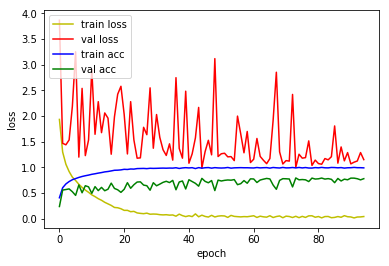

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.1385 - acc: 0.7570
Loss: 1.1384778298569123 Accuracy: 0.7570093

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9517 - acc: 0.4023
Epoch 00001: val_loss improved from inf to 2.33867, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_7_conv_checkpoint/001-2.3387.hdf5
36805/36805 [==============================] - 203s 6ms/sample - loss: 1.9517 - acc: 0.4023 - val_loss: 2.3387 - val_acc: 0.3422
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3123 - acc: 0.5967
Epoch 00002: val_loss improved from 2.33867 to 1.40056, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_7_conv_checkpoint/002-1.4006.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 1.3125 - acc: 0.5966 - val_loss: 1.4006 - val_acc: 0.5740
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1207 - acc: 0.9680
Epoch 00028: val_loss improved from 0.54268 to 0.53493, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_7_conv_checkpoint/028-0.5349.hdf5
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.1207 - acc: 0.9680 - val_loss: 0.5349 - val_acc: 0.8574
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1060 - acc: 0.9719
Epoch 00029: val_loss did not improve from 0.53493
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.1062 - acc: 0.9719 - val_loss: 0.6469 - val_acc: 0.8258
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1243 - acc: 0.9665
Epoch 00030: val_loss did not improve from 0.53493
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.1243 - acc: 0.9665 - val_loss: 0.5489 - val_acc: 0.8530
Epoch 31/500
36800/36805 [============================>.] - ETA:

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0195 - acc: 0.9971
Epoch 00057: val_loss did not improve from 0.44550
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0195 - acc: 0.9971 - val_loss: 0.7536 - val_acc: 0.8304
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9878
Epoch 00058: val_loss did not improve from 0.44550
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0475 - acc: 0.9878 - val_loss: 0.5073 - val_acc: 0.8763
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0582 - acc: 0.9851
Epoch 00059: val_loss did not improve from 0.44550
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0582 - acc: 0.9851 - val_loss: 0.8409 - val_acc: 0.8069
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9919
Epoch 00060: val_loss did not improve from 0.44550
36805/36805 [========

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9938
Epoch 00086: val_loss did not improve from 0.40617
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0258 - acc: 0.9938 - val_loss: 0.5957 - val_acc: 0.8698
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9943
Epoch 00087: val_loss did not improve from 0.40617
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0251 - acc: 0.9943 - val_loss: 0.4481 - val_acc: 0.8915
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9940
Epoch 00088: val_loss did not improve from 0.40617
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0254 - acc: 0.9939 - val_loss: 0.5883 - val_acc: 0.8763
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9908
Epoch 00089: val_loss did not improve from 0.40617
36805/36805 [========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9952
Epoch 00115: val_loss did not improve from 0.39007
36805/36805 [==============================] - 169s 5ms/sample - loss: 0.0210 - acc: 0.9952 - val_loss: 0.5476 - val_acc: 0.8819
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0135 - acc: 0.9971
Epoch 00116: val_loss did not improve from 0.39007
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0135 - acc: 0.9971 - val_loss: 0.8212 - val_acc: 0.8318
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0209 - acc: 0.9951
Epoch 00117: val_loss did not improve from 0.39007
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0213 - acc: 0.9950 - val_loss: 0.5160 - val_acc: 0.8847
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9909
Epoch 00118: val_loss did not improve from 0.39007
36805/36805 [====

Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9992
Epoch 00145: val_loss did not improve from 0.39007
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0059 - acc: 0.9991 - val_loss: 0.4230 - val_acc: 0.9103
Epoch 146/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9936
Epoch 00146: val_loss did not improve from 0.39007
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0243 - acc: 0.9936 - val_loss: 0.4850 - val_acc: 0.8956
Epoch 147/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9961
Epoch 00147: val_loss did not improve from 0.39007
36805/36805 [==============================] - 168s 5ms/sample - loss: 0.0160 - acc: 0.9961 - val_loss: 0.4563 - val_acc: 0.9038
Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9974
Epoch 00148: val_loss did not improve from 0.39007
36805/36805 [====

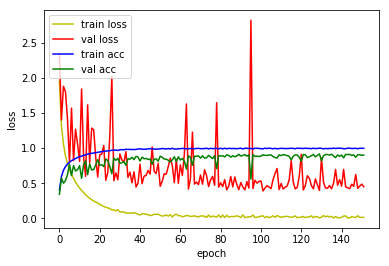

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.5005 - acc: 0.8839
Loss: 0.5005481078741087 Accuracy: 0.88390446

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9064 - acc: 0.4202
Epoch 00001: val_loss improved from inf to 1.57002, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_8_conv_checkpoint/001-1.5700.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 1.9064 - acc: 0.4202 - val_loss: 1.5700 - val_acc: 0.5292
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1789 - acc: 0.6473
Epoch 00002: val_loss improved from 1.57002 to 1.11876, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_8_conv_checkpoint/002-1.1188.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 1.1790 - acc: 0.6472 - val_loss: 1.1188 - val_acc: 0.6643
Epoch 3/500
36800/36805 [============================>.] -

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0909 - acc: 0.9745
Epoch 00026: val_loss did not improve from 0.29506
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0910 - acc: 0.9745 - val_loss: 0.3310 - val_acc: 0.9038
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9746
Epoch 00027: val_loss improved from 0.29506 to 0.27365, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_8_conv_checkpoint/027-0.2737.hdf5
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0960 - acc: 0.9746 - val_loss: 0.2737 - val_acc: 0.9192
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0729 - acc: 0.9811
Epoch 00028: val_loss did not improve from 0.27365
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0731 - acc: 0.9810 - val_loss: 0.3441 - val_acc: 0.9040
Epoch 29/500
36800/36805 [============================>.] - ETA:

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9883
Epoch 00054: val_loss did not improve from 0.22958
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0444 - acc: 0.9883 - val_loss: 0.2583 - val_acc: 0.9366
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9907
Epoch 00055: val_loss did not improve from 0.22958
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0351 - acc: 0.9907 - val_loss: 0.2421 - val_acc: 0.9394
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0124 - acc: 0.9980
Epoch 00056: val_loss did not improve from 0.22958
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0124 - acc: 0.9980 - val_loss: 0.2554 - val_acc: 0.9415
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0231 - acc: 0.9947
Epoch 00057: val_loss did not improve from 0.22958
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0066 - acc: 0.9990
Epoch 00083: val_loss improved from 0.20613 to 0.20471, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_8_conv_checkpoint/083-0.2047.hdf5
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0066 - acc: 0.9990 - val_loss: 0.2047 - val_acc: 0.9499
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0151 - acc: 0.9965
Epoch 00084: val_loss did not improve from 0.20471
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0152 - acc: 0.9964 - val_loss: 0.2626 - val_acc: 0.9422
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9890
Epoch 00085: val_loss did not improve from 0.20471
36805/36805 [==============================] - 171s 5ms/sample - loss: 0.0385 - acc: 0.9889 - val_loss: 0.2483 - val_acc: 0.9401
Epoch 86/500
36800/36805 [============================>.] - ETA:

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9996
Epoch 00112: val_loss did not improve from 0.20159
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0031 - acc: 0.9996 - val_loss: 0.2094 - val_acc: 0.9520
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9929
Epoch 00113: val_loss did not improve from 0.20159
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0263 - acc: 0.9929 - val_loss: 0.2536 - val_acc: 0.9422
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0114 - acc: 0.9972
Epoch 00114: val_loss did not improve from 0.20159
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0114 - acc: 0.9971 - val_loss: 0.2495 - val_acc: 0.9418
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9961
Epoch 00115: val_loss did not improve from 0.20159
36805/36805 [====

36800/36805 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9920
Epoch 00141: val_loss did not improve from 0.19408
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0268 - acc: 0.9920 - val_loss: 0.2117 - val_acc: 0.9515
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9996
Epoch 00142: val_loss did not improve from 0.19408
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0027 - acc: 0.9996 - val_loss: 0.2053 - val_acc: 0.9532
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9996
Epoch 00143: val_loss did not improve from 0.19408
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0030 - acc: 0.9996 - val_loss: 0.2748 - val_acc: 0.9341
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9923
Epoch 00144: val_loss did not improve from 0.19408
36805/36805 [==================

Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0052 - acc: 0.9987
Epoch 00170: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0052 - acc: 0.9988 - val_loss: 0.2187 - val_acc: 0.9539
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9995
Epoch 00171: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0029 - acc: 0.9995 - val_loss: 0.2011 - val_acc: 0.9553
Epoch 172/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9965
Epoch 00172: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0116 - acc: 0.9965 - val_loss: 0.3873 - val_acc: 0.9180
Epoch 173/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9961
Epoch 00173: val_loss did not improve from 0.19056
36805/36805 [====

Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9995
Epoch 00200: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0027 - acc: 0.9995 - val_loss: 0.2479 - val_acc: 0.9518
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0123 - acc: 0.9964
Epoch 00201: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0123 - acc: 0.9964 - val_loss: 0.2464 - val_acc: 0.9476
Epoch 202/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0019 - acc: 0.9998
Epoch 00202: val_loss did not improve from 0.19056
36805/36805 [==============================] - 170s 5ms/sample - loss: 0.0019 - acc: 0.9998 - val_loss: 0.2065 - val_acc: 0.9571
Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9995
Epoch 00203: val_loss did not improve from 0.19056
36805/36805 [====

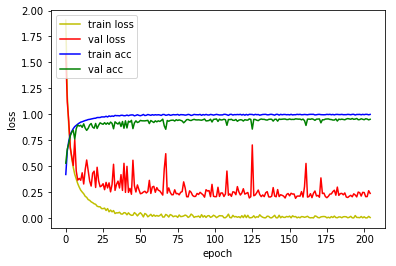

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2650 - acc: 0.9406
Loss: 0.26498853739153744 Accuracy: 0.9406023

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6603 - acc: 0.4951
Epoch 00001: val_loss improved from inf to 1.27673, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_9_conv_checkpoint/001-1.2767.hdf5
36805/36805 [==============================] - 225s 6ms/sample - loss: 1.6603 - acc: 0.4951 - val_loss: 1.2767 - val_acc: 0.6131
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8492 - acc: 0.7391
Epoch 00002: val_loss improved from 1.27673 to 1.18780, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_tanh_BN_9_conv_checkpoint/002-1.1878.hdf5
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.8492 - acc: 0.7391 - val_loss: 1.1878 - val_acc: 0.6427
Epoch 3/500
36800/36805 [============================>.] -

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9917
Epoch 00025: val_loss did not improve from 0.20589
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0333 - acc: 0.9917 - val_loss: 0.2495 - val_acc: 0.9329
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0307 - acc: 0.9922
Epoch 00026: val_loss did not improve from 0.20589
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0307 - acc: 0.9922 - val_loss: 0.2776 - val_acc: 0.9215
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9910
Epoch 00027: val_loss did not improve from 0.20589
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0349 - acc: 0.9910 - val_loss: 0.4639 - val_acc: 0.8656
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9877
Epoch 00028: val_loss did not improve from 0.20589
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9986
Epoch 00054: val_loss did not improve from 0.19599
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0065 - acc: 0.9986 - val_loss: 0.2413 - val_acc: 0.9418
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0168 - acc: 0.9954
Epoch 00055: val_loss did not improve from 0.19599
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0169 - acc: 0.9954 - val_loss: 0.2855 - val_acc: 0.9313
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9937
Epoch 00056: val_loss did not improve from 0.19599
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0213 - acc: 0.9938 - val_loss: 0.2185 - val_acc: 0.9462
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9972
Epoch 00057: val_loss did not improve from 0.19599
36805/36805 [========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9994
Epoch 00083: val_loss did not improve from 0.18629
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0037 - acc: 0.9994 - val_loss: 0.1967 - val_acc: 0.9567
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9994
Epoch 00084: val_loss did not improve from 0.18629
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0032 - acc: 0.9994 - val_loss: 0.2032 - val_acc: 0.9574
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9937
Epoch 00085: val_loss did not improve from 0.18629
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0206 - acc: 0.9938 - val_loss: 0.2579 - val_acc: 0.9383
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9987
Epoch 00086: val_loss did not improve from 0.18629
36805/36805 [========

Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9980
Epoch 00112: val_loss did not improve from 0.17501
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0076 - acc: 0.9980 - val_loss: 0.3354 - val_acc: 0.9241
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9936
Epoch 00113: val_loss did not improve from 0.17501
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0207 - acc: 0.9936 - val_loss: 0.2336 - val_acc: 0.9476
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9963
Epoch 00114: val_loss did not improve from 0.17501
36805/36805 [==============================] - 165s 4ms/sample - loss: 0.0141 - acc: 0.9963 - val_loss: 0.1948 - val_acc: 0.9599
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9992
Epoch 00115: val_loss did not improve from 0.17501
36805/36805 [====

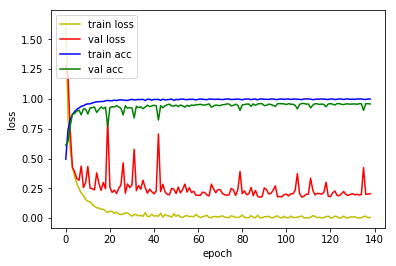

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2362 - acc: 0.9464
Loss: 0.23617102964350864 Accuracy: 0.94641745



In [10]:
base = '1D_CNN_custom_conv_3_VGG_tanh_BN'

for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_tanh_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          

4815/4815 [==============================] - 9s 2ms/sample - loss: 2.4855 - acc: 0.5333
Loss: 2.4855427053734767 Accuracy: 0.53333336

1D_CNN_custom_conv_3_VGG_tanh_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_123 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_124 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)

4815/4815 [==============================] - 9s 2ms/sample - loss: 1.1385 - acc: 0.7570
Loss: 1.1384778298569123 Accuracy: 0.7570093

1D_CNN_custom_conv_3_VGG_tanh_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation) 

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2650 - acc: 0.9406
Loss: 0.26498853739153744 Accuracy: 0.9406023

1D_CNN_custom_conv_3_VGG_tanh_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_179 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_180 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activation

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2362 - acc: 0.9464
Loss: 0.23617102964350864 Accuracy: 0.94641745


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_tanh_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          

4815/4815 [==============================] - 10s 2ms/sample - loss: 3.4309 - acc: 0.5279
Loss: 3.430877184050848 Accuracy: 0.52793354

1D_CNN_custom_conv_3_VGG_tanh_BN_5_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_123 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_110 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_124 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_111 (Activation)

4815/4815 [==============================] - 11s 2ms/sample - loss: 1.3336 - acc: 0.7485
Loss: 1.3336144921935607 Accuracy: 0.74849427

1D_CNN_custom_conv_3_VGG_tanh_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_132 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_133 (Activation

4815/4815 [==============================] - 11s 2ms/sample - loss: 0.3320 - acc: 0.9308
Loss: 0.33197585187527434 Accuracy: 0.93084115

1D_CNN_custom_conv_3_VGG_tanh_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
batch_normalization_v1_179 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_162 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
batch_normalization_v1_180 ( (None, 16000, 64)         256       
_________________________________________________________________
activation_163 (Activatio

4815/4815 [==============================] - 12s 2ms/sample - loss: 0.2795 - acc: 0.9448
Loss: 0.2794641652818564 Accuracy: 0.944756
